# KAGGLE: M5 FORECASTING

https://www.kaggle.com/c/m5-forecasting-accuracy/data

---

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import pmdarima as pm

---

## Import data

In [2]:
filename = 'data/sales_train_validation.csv'
df_raw = pd.read_csv(filename)

In [3]:
df_raw.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1


In [4]:
filename = 'data/calendar.csv'
calendar = pd.read_csv(filename, parse_dates=['date'], infer_datetime_format=True, dayfirst=True)

In [5]:
calendar.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,5_Sat,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


In [6]:
filename = 'data/sell_prices.csv'
price = pd.read_csv(filename)

In [7]:
price.head(1)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58


---

## Preprocessing

In [8]:
PRODUCT = 1
MIN_PERIOD = pd.to_datetime('01-09-2011', format='%d-%m-%Y')

### Calendar: mapping date <> d

In [9]:
mapping_calendar = calendar[['date', 'd', 'wm_yr_wk', 'weekday', 'month', 'year']].copy()

### Calendar: holidays name, type

In [10]:
holidays = calendar[['d', 'event_name_1', 'event_type_1']].copy()
holidays.dropna(inplace=True)

In [11]:
filter_holidays = ['SuperBowl', 'ValentinesDay', 'Easter', 'NBAFinalsEnd', 'Thanksgiving', 'Christmas', 'NewYear',
                  "Mother's day", 'NBAFinalsStart','NBAFinalsEnd', "Father's day", 'IndependenceDay', 
                   'Ramadan starts', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha']
flag = holidays['event_name_1'].apply(lambda x: x in filter_holidays)
holidays = holidays[flag]
holidays.rename(columns={'event_name_1':'holiday'}, inplace=True)
holidays.head()

,d,holiday,event_type_1
8,d_9,SuperBowl,Sporting
16,d_17,ValentinesDay,Cultural
85,d_86,Easter,Cultural
99,d_100,Mother's day,Cultural
122,d_123,NBAFinalsStart,Sporting


### Training data: cut data (get top N products)

In [12]:
df = df_raw.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1).copy()
df.set_index('id', inplace=True)

In [13]:
df['total'] = df.sum(axis=1)

In [14]:
df_sorted = df[['total']].sort_values(by='total', ascending=False)

In [15]:
# n = 1
# top_id = [df_sorted.index[i] for i in range(n)]
top_id = df_sorted.index[PRODUCT]
top_id

'FOODS_3_586_TX_2_validation'

In [16]:
df_raw['flag'] = df_raw['id'].apply(lambda x: x in top_id)

In [17]:
df_filter = df_raw[df_raw['flag']]
df_filter.drop('flag', axis=1, inplace=True)
df_filter.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
18055,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,98,85,47,56,...,80,78,102,54,67,57,59,80,100,75


### Training data: drop columns

In [18]:
drop_cols = ['dept_id', 'cat_id', 'state_id']
df_filter.drop(drop_cols, axis=1, inplace=True)

### Unpivot weeks

In [19]:
id_vars = ['id', 'item_id', 'store_id']
df = df_filter.melt(id_vars=id_vars, var_name='d')
df.tail()

,id,item_id,store_id,d,value
1908,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1909,57
1909,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1910,59
1910,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1911,80
1911,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1912,100
1912,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1913,75


### Join date: replace d with dd-mm-yy

In [20]:
df = pd.merge(df, mapping_calendar[['d', 'date', 'wm_yr_wk', 'weekday', 'month', 'year']], how='left', 
              left_on='d', right_on='d')
df['date'] = pd.to_datetime(df['date'])

In [21]:
df.tail(1)

,id,item_id,store_id,d,value,date,wm_yr_wk,weekday,month,year
1912,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1913,75,2016-04-24,11613,6_Sun,4,2016


In [22]:
flag = df['date'] >= MIN_PERIOD
df = df[flag]

### Join date: holidays

In [23]:
df = pd.merge(df, holidays[['d', 'holiday']], how='left', 
              left_on='d', right_on='d')
df['holiday'].fillna(0, inplace=True)
df.drop('d', axis=1, inplace=True)

In [24]:
df.head()

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday
0,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,144,2011-09-01,11131,3_Thu,9,2011,0
1,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,147,2011-09-02,11131,4_Fri,9,2011,0
2,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,177,2011-09-03,11132,5_Sat,9,2011,0
3,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,88,2011-09-04,11132,6_Sun,9,2011,0
4,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,138,2011-09-05,11132,0_Mon,9,2011,LaborDay


### Join prices

In [25]:
df = pd.merge(df, price, how='left', 
              left_on=['item_id', 'store_id', 'wm_yr_wk'], 
              right_on=['item_id', 'store_id', 'wm_yr_wk'])

In [26]:
df.head(1)

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday,sell_price
0,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,144,2011-09-01,11131,3_Thu,9,2011,0,1.48


In [27]:
df.sort_values(by='date', inplace=True)

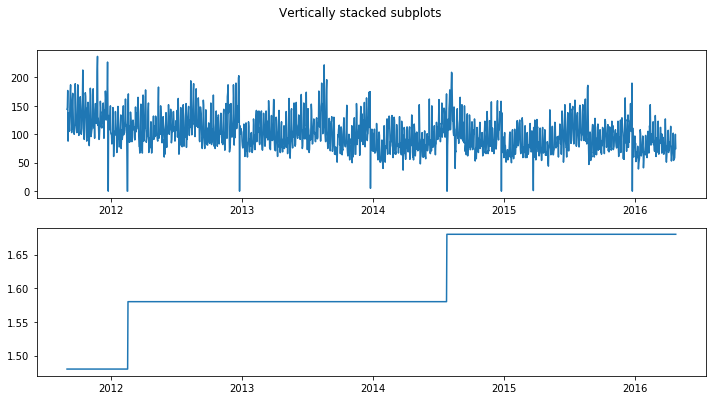

In [28]:
fig, axs = plt.subplots(2, figsize=(12, 6))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df['date'], df['value'])
axs[1].plot(df['date'], df['sell_price'])
plt.show()

In [29]:
df.tail()

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday,sell_price
1693,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,57,2016-04-20,11612,2_Wed,4,2016,0,1.68
1694,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,59,2016-04-21,11612,3_Thu,4,2016,0,1.68
1695,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,80,2016-04-22,11612,4_Fri,4,2016,0,1.68
1696,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,100,2016-04-23,11613,5_Sat,4,2016,0,1.68
1697,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,75,2016-04-24,11613,6_Sun,4,2016,0,1.68


### Add: weeknum

In [30]:
df['weeknum'] = df['date'].dt.week

---

## Exploratory Data

### Daily Trends

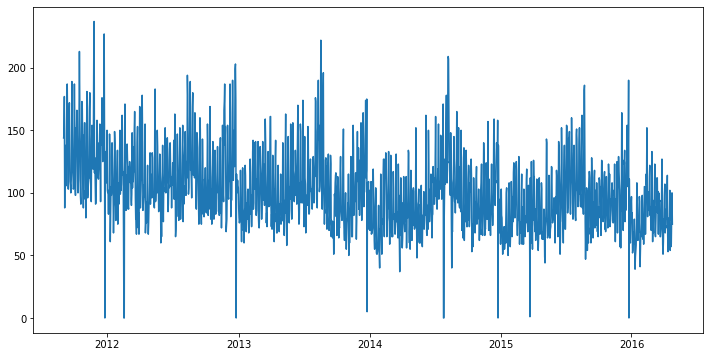

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'])
plt.show()

### Sales by year

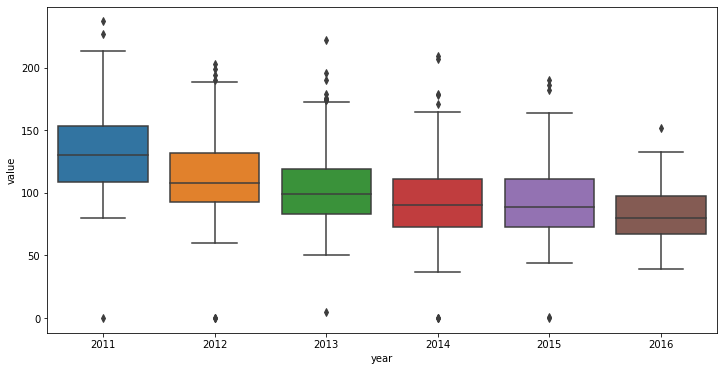

In [32]:
plt.figure(figsize=(12, 6))
flag = df['year'] > 2010
sns.boxplot(x='year', y='value', data=df[flag])
plt.show()

### Sales by month

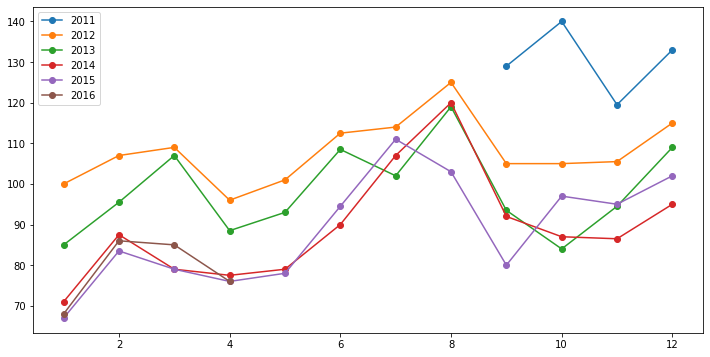

In [33]:
flag = df['year'] > 2010
df_filter = df[flag]
plt.figure(figsize=(12, 6))
for year in df_filter['year'].unique():
    flag_year = df_filter['year'] == year
    agg = df_filter[flag_year].groupby(by='month').median()
    plt.plot(agg['value'], '-o', label=year)
plt.legend()

### Sales by weekday

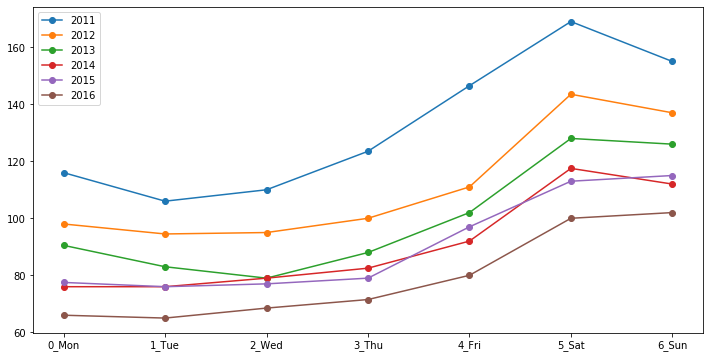

In [34]:
flag = df['year'] > 2010
df_filter = df[flag]
plt.figure(figsize=(12, 6))
for year in df_filter['year'].unique():
    flag_year = df_filter['year'] == year
    agg = df_filter[flag_year].groupby(by='weekday').median()
    plt.plot(agg['value'], '-o', label=year)
plt.legend()
plt.show()

### Sales Distribution

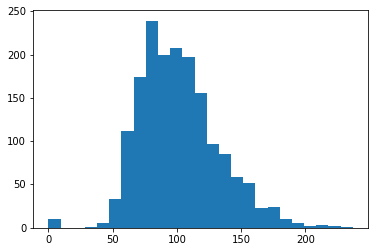

In [35]:
plt.hist(df['value'], bins=25)
plt.show()

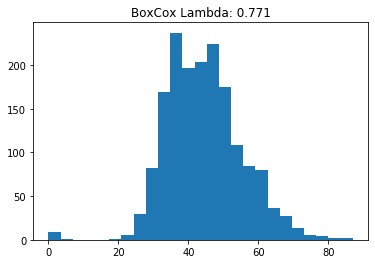

In [36]:
df['adj_value'], boxcox_lambda = boxcox(df['value']+1)
plt.hist(df['adj_value'], bins=25)
title = 'BoxCox Lambda: {:.3f}'.format(boxcox_lambda)
plt.title(title)
plt.show()

---

## Aggregating monthly data

In [37]:
metric = 'value'
df_month = df[['id', 'month', 'year', metric]]
df_month['day'] = '01-' + df['month'].apply(str) + '-' + df['year'].apply(str)
df_month['day'] = pd.to_datetime(df_month['day'], format='%d-%m-%Y')
agg_month = df_month.groupby(by='day').mean()[[metric]]

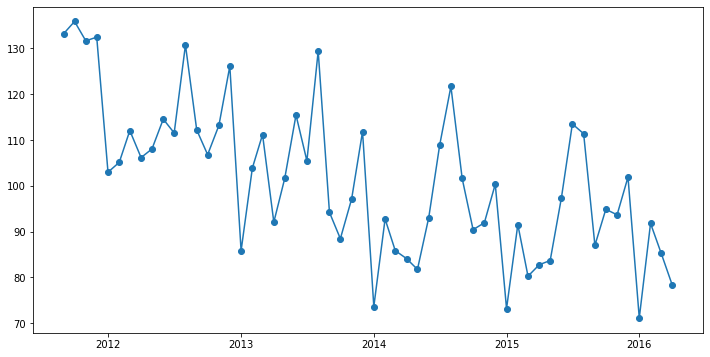

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(agg_month, '-o')
plt.show()

---

## Auxiliary Functions

In [39]:
def mape(df, actual, model):
    diff = df[actual] - df[model]
    return np.mean(abs(diff/df[actual]))

In [40]:
def plot_model(train, test, model):
    plt.figure(figsize=(12, 6))
    plt.plot(train[metric], label='train')
    plt.plot(test[metric], label='test: actual')
    plt.plot(test[model], label='test: '+model)
    cmape = mape(test, metric, model)
    title = 'Model: ' + model + ' (MAPE: ' + str(round(cmape, 4)) + ')'
    plt.title(title, fontsize=15)
    plt.legend()
    plt.show()

### Train Test Split

In [41]:
split = .8
n_split = int(agg_month.shape[0]*split)

In [42]:
train = agg_month[:n_split]
test = agg_month[n_split:]

---

## Monthly Model: without exogenous variables

### Benchmark: Naive Model: same average

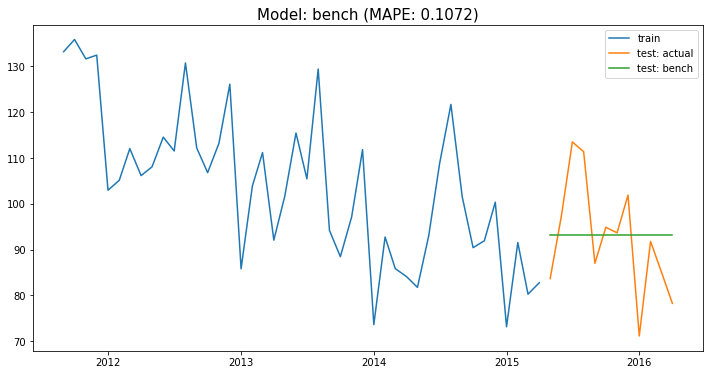

In [43]:
name = 'bench'
test[name] = train.rolling(12).mean().values[-1][0]
plot_model(train, test, name)

### Model: Auto ARIMA

In [44]:
name = 'sarima'
smodel = pm.auto_arima(y=train[metric],
                       test='adf',
                       start_p=0, max_p=3,
                       start_q=0, max_q=3,
                       start_d=0, max_d=1,
                       seasonal=True, m=12,
                       start_D=0, max_D=1,
                       start_P=0, max_P=3,
                       start_Q=0, max_Q=3,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=236.542, BIC=239.410, Fit time=0.134 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=231.101, BIC=236.837, Fit time=0.460 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=231.086, BIC=235.388, Fit time=0.085 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=229.402, BIC=235.138, Fit time=0.143 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=230.329, BIC=237.499, Fit time=0.152 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=232.194, BIC=240.798, Fit time=0.219 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=230.071, BIC=23

In [45]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   44
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -110.701
Date:                            Thu, 16 Apr 2020   AIC                            229.402
Time:                                    00:00:12   BIC                            235.138
Sample:                                         0   HQIC                           231.271
                                             - 44                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3408      1.608      0.834      0.404      -1.811       4.493
ar.L1         -0.6122      0.226     -2.714      0.007      -1.054      -0.170
ar.L2         -0.3312      0.154     -2.147      0.032      -0.634      -0.029
sigma2        72.8886     20.033      3.638      0.000      33.624     112.153
===================================================================================
Ljung-Box (Q):                       24.33   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.76   Prob(JB):                         0.91
Heteroskedasticity (H):               1.46   Skew:                             0.16
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
test[name], ci = smodel.predict(n_periods=test.shape[0], return_conf_int=True)

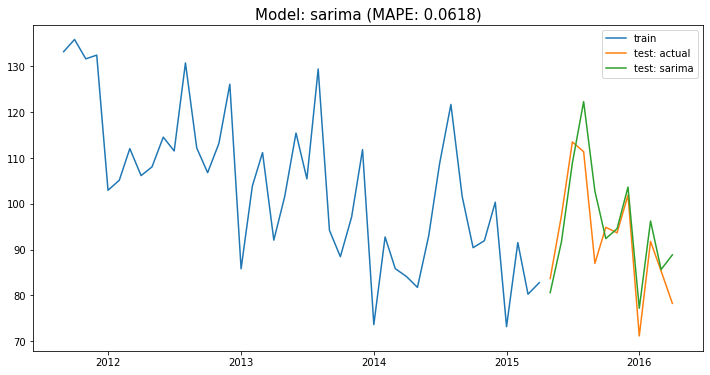

In [47]:
plot_model(train, test, name)

## Daily Model: Machine Learning

In [48]:
df.head()

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday,sell_price,weeknum,adj_value
0,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,144,2011-09-01,11131,3_Thu,9,2011,0,1.48,35,58.922000
1,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,147,2011-09-02,11131,4_Fri,9,2011,0,1.48,35,59.880625
2,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,177,2011-09-03,11132,5_Sat,9,2011,0,1.48,35,69.239334
3,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,88,2011-09-04,11132,6_Sun,9,2011,0,1.48,35,40.031591
4,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,138,2011-09-05,11132,0_Mon,9,2011,LaborDay,1.48,36,56.990987


In [49]:
dfc = df.drop(['id', 'item_id', 'store_id', 'wm_yr_wk', 'year', 'weeknum'], axis=1).copy()

In [50]:
min_date = dfc['date'].min()
dfc['dt'] = df['date'].apply(lambda x: (x-min_date).days)
dfc['dt2'] = dfc['dt']**2
dfc.set_index('date', inplace=True)

In [51]:
df_dummies = pd.get_dummies(dfc, columns=['weekday', 'month', 'holiday'], drop_first=True)
df_dummies.head()

,value,sell_price,adj_value,dt,dt2,weekday_1_Tue,weekday_2_Wed,weekday_3_Thu,weekday_4_Fri,weekday_5_Sat,...,holiday_IndependenceDay,holiday_LaborDay,holiday_Mother's day,holiday_NBAFinalsEnd,holiday_NBAFinalsStart,holiday_NewYear,holiday_Ramadan starts,holiday_SuperBowl,holiday_Thanksgiving,holiday_ValentinesDay
date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,144,1.48,58.922000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-09-02,147,1.48,59.880625,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2011-09-03,177,1.48,69.239334,2,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2011-09-04,88,1.48,40.031591,3,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-09-05,138,1.48,56.990987,4,16,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_dummies.drop('value', axis=1))

In [54]:
X_std = pd.DataFrame(X_std, columns=df_dummies.drop('value', axis=1).columns, index=df_dummies.index)

In [55]:
X_std.head()

,sell_price,adj_value,dt,dt2,weekday_1_Tue,weekday_2_Wed,weekday_3_Thu,weekday_4_Fri,weekday_5_Sat,weekday_6_Sun,...,holiday_IndependenceDay,holiday_LaborDay,holiday_Mother's day,holiday_NBAFinalsEnd,holiday_NBAFinalsStart,holiday_NewYear,holiday_Ramadan starts,holiday_SuperBowl,holiday_Thanksgiving,holiday_ValentinesDay
date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,-2.017477,1.336108,-1.731031,-1.117664,-0.407687,-0.407687,2.446968,-0.408669,-0.408669,-0.408669,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-02,-2.017477,1.424509,-1.728991,-1.117663,-0.407687,-0.407687,-0.408669,2.446968,-0.408669,-0.408669,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-03,-2.017477,2.287527,-1.726951,-1.117659,-0.407687,-0.407687,-0.408669,-0.408669,2.446968,-0.408669,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-04,-2.017477,-0.405880,-1.724911,-1.117653,-0.407687,-0.407687,-0.408669,-0.408669,-0.408669,2.446968,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-05,-2.017477,1.158039,-1.722871,-1.117645,-0.407687,-0.407687,-0.408669,-0.408669,-0.408669,-0.408669,...,-0.048593,18.401087,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345


In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
lr = LinearRegression()

In [58]:
lr.fit(X=X_std, y=df_dummies['value'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
y_pred = lr.predict(X_std)

In [60]:
y_pred.shape

(1698,)

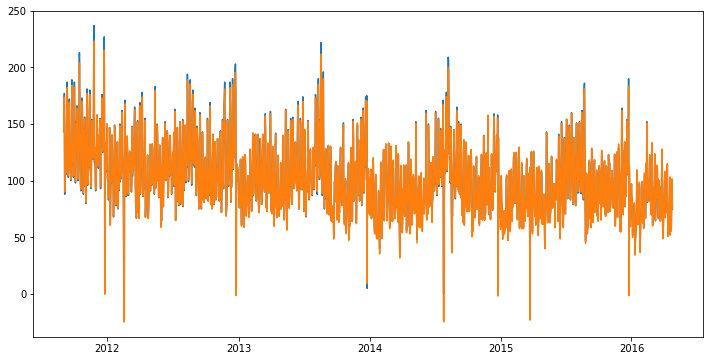

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(df_dummies['value'])
plt.plot(df_dummies.index, y_pred)
plt.show()

In [62]:
diff = (y_pred - df_dummies['value'])
mae = np.mean(abs(diff))

In [63]:
mae

1.0067111996197498

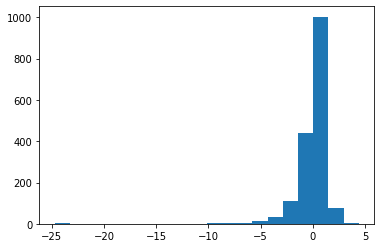

In [65]:
plt.hist(diff, bins=20)
plt.show()

In [66]:
coeff = pd.DataFrame(lr.coef_, index=X_std.columns)
coeff

,0
sell_price,-0.170385
adj_value,30.886796
dt,-0.639372
dt2,0.592153
weekday_1_Tue,0.015460
weekday_2_Wed,-0.015379
weekday_3_Thu,0.000843
weekday_4_Fri,0.078163
weekday_5_Sat,0.417105
weekday_6_Sun,0.304095


In [ ]:
flag = df_dummies.index.year==2015
plt.figure(figsize=(12, 6))
plt.plot(df_dummies[flag]['value'])
plt.plot(df_dummies[flag].index, y_pred[flag])
plt.show()